In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import cartopy as cp
from matplotlib.patches import FancyArrowPatch
from scipy.ndimage import map_coordinates
import metpy.calc as mpcalc
from geographiclib.geodesic import Geodesic
from utils_datetime import *
from utils_filter import *

In [ ]:
grid_outlooks = xr.open_dataset('data/outlooks/grid_outlooks.nc')
grid_outlooks = grid_outlooks.sel(time = grid_outlooks['time'] >= '200203300000')

In [ ]:
# creates new displacements dataset by keeping data (get rid of shifts and div) 
# but changing x and y coords so that (0, 0) is at max or weighted center of outlook (or pph?). Since highest risk is seen as "center" of what will happen, even if weaker storms are focused to one direction
# then calculate things like shifts of quadrents

# note: grids will not quite be aligned when each is centered over a different point, but probably close enough


# finding x and y to make center for each date
grouped = grid_outlooks['prob'].groupby('time')

# Step 1: Find all points with the maximum prob for each day and compute mean coordinates
def find_mean_coords(group):
    max_prob = group.max()  # Maximum value in the group
    if max_prob == 0:
        mean_x = group['x'].mean().item()
        mean_y = group['y'].mean().item()
    else:
        # Select all points with prob == max_prob
        max_points = group.where(group == max_prob, drop=True)
        # Compute the mean of x and y
        mean_x = max_points['x'].mean().item()
        mean_y = max_points['y'].mean().item()
    # Round to nearest integers
    nearest_x = round(mean_x)
    nearest_y = round(mean_y)
    # Return as a Dataset
    return xr.Dataset({'nearest_x': nearest_x, 'nearest_y': nearest_y})

# Apply the function to each group
center_coords = grouped.map(find_mean_coords)
center_coords

del grid_outlooks, grouped

In [ ]:
# Extract nearest_x and nearest_y
nearest_x = center_coords['nearest_x']
nearest_y = center_coords['nearest_y']


# Re-center displacements
def recenter_displacements(displacements, nearest_x, nearest_y):
    # Shift x and y coordinates based on nearest_x, nearest_y for each time
    new_x = displacements['x'] - nearest_x
    new_y = displacements['y'] - nearest_y
    
    # Assign shifted coordinates
    displacements = displacements.assign_coords({
        'x': new_x,
        'y': new_y
    })
    
    # Update lat and lon to depend on time, x, and y
    
    return displacements
# Initialize an empty list to store the recentered displacements



for dataset_location in ['data/pph/labelled_pph', 'data/displacement/displacements', 'data/outlooks/grid_outlooks', ]:
    print(dataset_location)
    recentered_list = []
    ds = xr.open_dataset(dataset_location + '.nc')
    ds = ds.sel(time = ds['time'] >= '200203300000')

    # Loop over each time step and apply recenter_displacements
    for t in range(len(ds.time)):
        # Get the current time slice of displacements
        displacement_slice = ds.isel(time=t)

        # Get the corresponding nearest_x and nearest_y for this time step
        nearest_x_t = nearest_x.isel(time=t)
        nearest_y_t = nearest_y.isel(time=t)

        # Apply the recentering function to the current time slice
        recentered_t = recenter_displacements(displacement_slice, nearest_x_t, nearest_y_t)

        # expanding needs to be done differently

        # Append the recentered displacements for this time slice
        recentered_list.append(recentered_t)
    print('combining')
    # Combine the recentered displacements back into a single xarray object
    recentered = xr.concat(recentered_list, dim='time')
    # Ensure proper ordering of dimensions
    #recentered = recentered.transpose('time', 'y', 'x', 'hazard')
    recentered.to_netcdf('~/recentered_data/' + dataset_location.split('/')[-1] + '_recentered.nc') 
    del recentered, recentered_list


In [ ]:
# open pph, outlook, and displacements
#test_time = ['201104270000', '201905310000']
# do something like how shifts and divergence are calculated but in each quadrent

pph_recentered = xr.open_dataset('~/recentered_data/labelled_pph_recentered.nc')
outlooks_recentered = xr.open_dataset('~/recentered_data/grid_outlooks_recentered.nc')
displacements_recentered = xr.open_dataset('~/recentered_data/displacements_recentered.nc')

In [8]:
hazard_types= ['Wind', 'Hail', 'Tornado', 'All Hazard']

pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}

In [ ]:


displacements_recentered = displacements_recentered.assign(e_shift_n = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(n_shift_n = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(total_div_n = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))

displacements_recentered = displacements_recentered.assign(e_shift_e = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(n_shift_e = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(total_div_e = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))

displacements_recentered = displacements_recentered.assign(e_shift_s = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(n_shift_s = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(total_div_s = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))

displacements_recentered = displacements_recentered.assign(e_shift_w = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(n_shift_w = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))
displacements_recentered = displacements_recentered.assign(total_div_w = (('time', 'hazard'), np.full((len(displacements_recentered['time']), len(hazard_types)), 0.0)))

for side in ['n', 'e', 's', 'w']:
    print(side)
    for hazard in hazard_types:

        print(hazard)

        e_shifts = []
        n_shifts = []
        total_divs = []

        hazard_dataset = displacements_recentered.sel(hazard = hazard)
        for date in displacements_recentered['time']:

            weights = outlooks_recentered.sel(time = date, outlook = outlook_key_dict[hazard])['prob']
            if side == 'n':
                mask = weights.y >= 0
            elif side == 'e':
                mask = weights.x >= 0
            elif side == 's':
                mask = weights.y <= 0
            elif side == 'w':
                mask = weights.x <= 0
            weights = weights.where(mask, 0).fillna(0).data
            
            if weights.max() == 0: # no outlook, so weight at pph
                weights = pph_recentered.sel(time = date)[pph_key_dict[hazard]].where(mask, 0).fillna(0).data
            if weights.max() == 0:
                weights = None
            hazard_time_dataset = hazard_dataset.sel(time = date)
            e_shift = np.average(hazard_time_dataset['e_flow'].fillna(0), weights = weights)
            n_shift = np.average(hazard_time_dataset['n_flow'].fillna(0), weights = weights)
            div = np.gradient(hazard_time_dataset['x_flow'].fillna(0))[1] + np.gradient(hazard_time_dataset['y_flow'].fillna(0))[0]
            total_div = np.average(div, weights = weights)

            displacements_recentered['e_shift_' + side].loc[dict(time = date, hazard = hazard)] = e_shift
            displacements_recentered['n_shift_' + side].loc[dict(time = date, hazard = hazard)] = n_shift
            displacements_recentered['total_div_' + side].loc[dict(time = date, hazard = hazard)] = total_div

In [ ]:
displacements_recentered.to_netcdf('~/recentered_data/displacements_recentered.nc')

# Exploring data

In [2]:
ds = xr.open_dataset('~/recentered_data/displacements_recentered.nc')
pph = xr.open_dataset('~/recentered_data/labelled_pph_recentered.nc')
grid_outlooks = xr.open_dataset('~/recentered_data/grid_outlooks_recentered.nc')

In [15]:
time_periods = ['all', '2002_2006', '2007_2011', '2012_2016', '2017_2023']
dpi = 1000
mdt = True

hazard_types= ['Wind', 'Hail', 'Tornado', 'All Hazard']

pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}

In [17]:
for time_period in time_periods:
    print(time_period)
    if time_period != 'all':
        year1 = time_period.split('_')[0]
        year2 = time_period.split('_')[1]
        this_ds = ds.sel(time = (ds['time'] >= year1 + '01010000') & (ds['time'] <= year2 + '12312359'))
        this_pph = pph.sel(time = (pph['time'] >= year1 + '01010000') & (pph['time'] <= year2 + '12312359'))
        this_grid_outlooks = grid_outlooks.sel(time = (grid_outlooks['time'] >= year1 + '01010000') & (grid_outlooks['time'] <= year2 + '12312359'))
    else:
        year1 = '2002'
        year2 = '2023'
        this_ds = ds
        this_pph = pph
        this_grid_outlooks = grid_outlooks

    mdt_pph = this_pph.sel(time = (this_pph['MAX_CAT'].isin(['MDT', 'HIGH'])))
    mdt_ds = this_ds.sel(time = (this_pph['MAX_CAT'].isin(['MDT', 'HIGH'])))
    mdt_outlooks = this_grid_outlooks.sel(time = (this_pph['MAX_CAT'].isin(['MDT', 'HIGH'])))

    mean_displacements = this_ds.mean(dim = 'time')
    mdt_mean_displacements = mdt_ds.mean(dim = 'time')

    mean_outlooks = this_grid_outlooks['prob'].mean(dim = 'time')
    mdt_mean_outlooks = mdt_outlooks['prob'].mean(dim = 'time')

    mean_pph = this_pph[['p_perfect_hail', 'p_perfect_wind', 'p_perfect_tor', 'p_perfect_totalsvr']].mean(dim = 'time')
    mdt_mean_pph = mdt_pph[['p_perfect_hail', 'p_perfect_wind', 'p_perfect_tor', 'p_perfect_totalsvr']].mean(dim = 'time')

    # plotting composite displacement
    print('composite displacement')
    s = slice(-20, 20)

    if mdt:
        mean_displacements_slice = mdt_mean_displacements.sel(x = s, y = s)
        mean_outlooks_slice = mdt_mean_outlooks.sel(x = s, y = s)
    else:
        mean_displacements_slice = mean_displacements.sel(x = s, y = s)
        mean_outlooks_slice = mean_outlooks.sel(x = s, y = s)

    x, y = np.meshgrid(mean_displacements_slice['x'],  
                    mean_displacements_slice['y']) 
    for hazard in hazard_types:
        print(hazard)
        x_flow = mean_displacements_slice.sel(hazard = hazard)['x_flow']
        y_flow = mean_displacements_slice.sel(hazard = hazard)['y_flow']
        c = plt.contourf(x, y, mean_outlooks_slice.sel(outlook = outlook_key_dict[hazard]) + .01, levels=[.02,.05,.10,.15,.30,.45,.60,1.00], alpha = .5, colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'])
        plt.quiver(x, y, x_flow, y_flow, scale=1, scale_units='xy')
        plt.gcf().set_dpi(1000)
        plt.colorbar(c, orientation="vertical", pad=0.01, aspect=50,fraction=.1)
        if mdt:
            plt.title(hazard + ' Displacement Composite for MDT+ Days ' + year1 + '-' + year2)
            plt.savefig('plots/results/colocated/composite_' + hazard + '_' + time_period + '.png', dpi = dpi)
        else:
            plt.title(hazard + ' Displacement Composite ' + year1 + '-' + year2)
            plt.savefig('plots/results/colocated/allcat_composite_' + hazard + '_' + time_period + '.png', dpi = dpi)
        #plt.show()
        plt.clf()

    # plotting composite of pph-outlook
    print('composite difference')
    s = slice(-20, 20)

    if mdt:
        mean_pph_slice = mdt_mean_pph.sel(x = s, y = s)
        mean_outlooks_slice = mdt_mean_outlooks.sel(x = s, y = s)
    else:
        mean_pph = mean_pph.sel(x = s, y = s)
        mean_outlooks_slice = mean_outlooks.sel(x = s, y = s)

    x, y = np.meshgrid(mean_pph_slice['x'],  
                    mean_pph_slice['y']) 
    for hazard in hazard_types:
        print(hazard)
        c = plt.contourf(x, y, mean_pph_slice[pph_key_dict[hazard]]/100 - mean_outlooks_slice.sel(outlook = outlook_key_dict[hazard]), levels = np.linspace(-.12, .12, 13), cmap ='PuOr')
        plt.contour(x, y, mean_outlooks_slice.sel(outlook = outlook_key_dict[hazard]) + .01, levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors = 'black', linestyles = 'dashed')
        plt.gcf().set_dpi(1000)
        plt.colorbar(c, orientation="vertical", pad=0.01, aspect=50,fraction=.1, extend = 'both')
        if mdt:
            plt.title(hazard + ' PPH - Outlook Composite on MDT+ Days ' + year1 + '-' + year2)
            plt.savefig('plots/results/colocated/composite' + hazard + '_' + time_period + '_dif.png', dpi = dpi)
        else:
            plt.title(hazard + ' PPH - Outlook Composite ' + year1 + '-' + year2)
            plt.savefig('plots/results/colocated/allcat_composite' + hazard + '_' + time_period + '_dif.png', dpi = dpi)
        #plt.show()
        plt.clf()

all
composite displacement
Wind
Hail
Tornado
All Hazard
composite difference
Wind
Hail
Tornado
All Hazard
2002_2006
composite displacement
Wind
Hail
Tornado
All Hazard
composite difference
Wind
Hail
Tornado
All Hazard
2007_2011
composite displacement
Wind
Hail
Tornado
All Hazard
composite difference
Wind
Hail
Tornado
All Hazard
2012_2016
composite displacement
Wind
Hail
Tornado
All Hazard
composite difference
Wind
Hail
Tornado
All Hazard
2017_2023
composite displacement
Wind
Hail
Tornado
All Hazard
composite difference
Wind
Hail
Tornado
All Hazard


<Figure size 6400x4800 with 0 Axes>

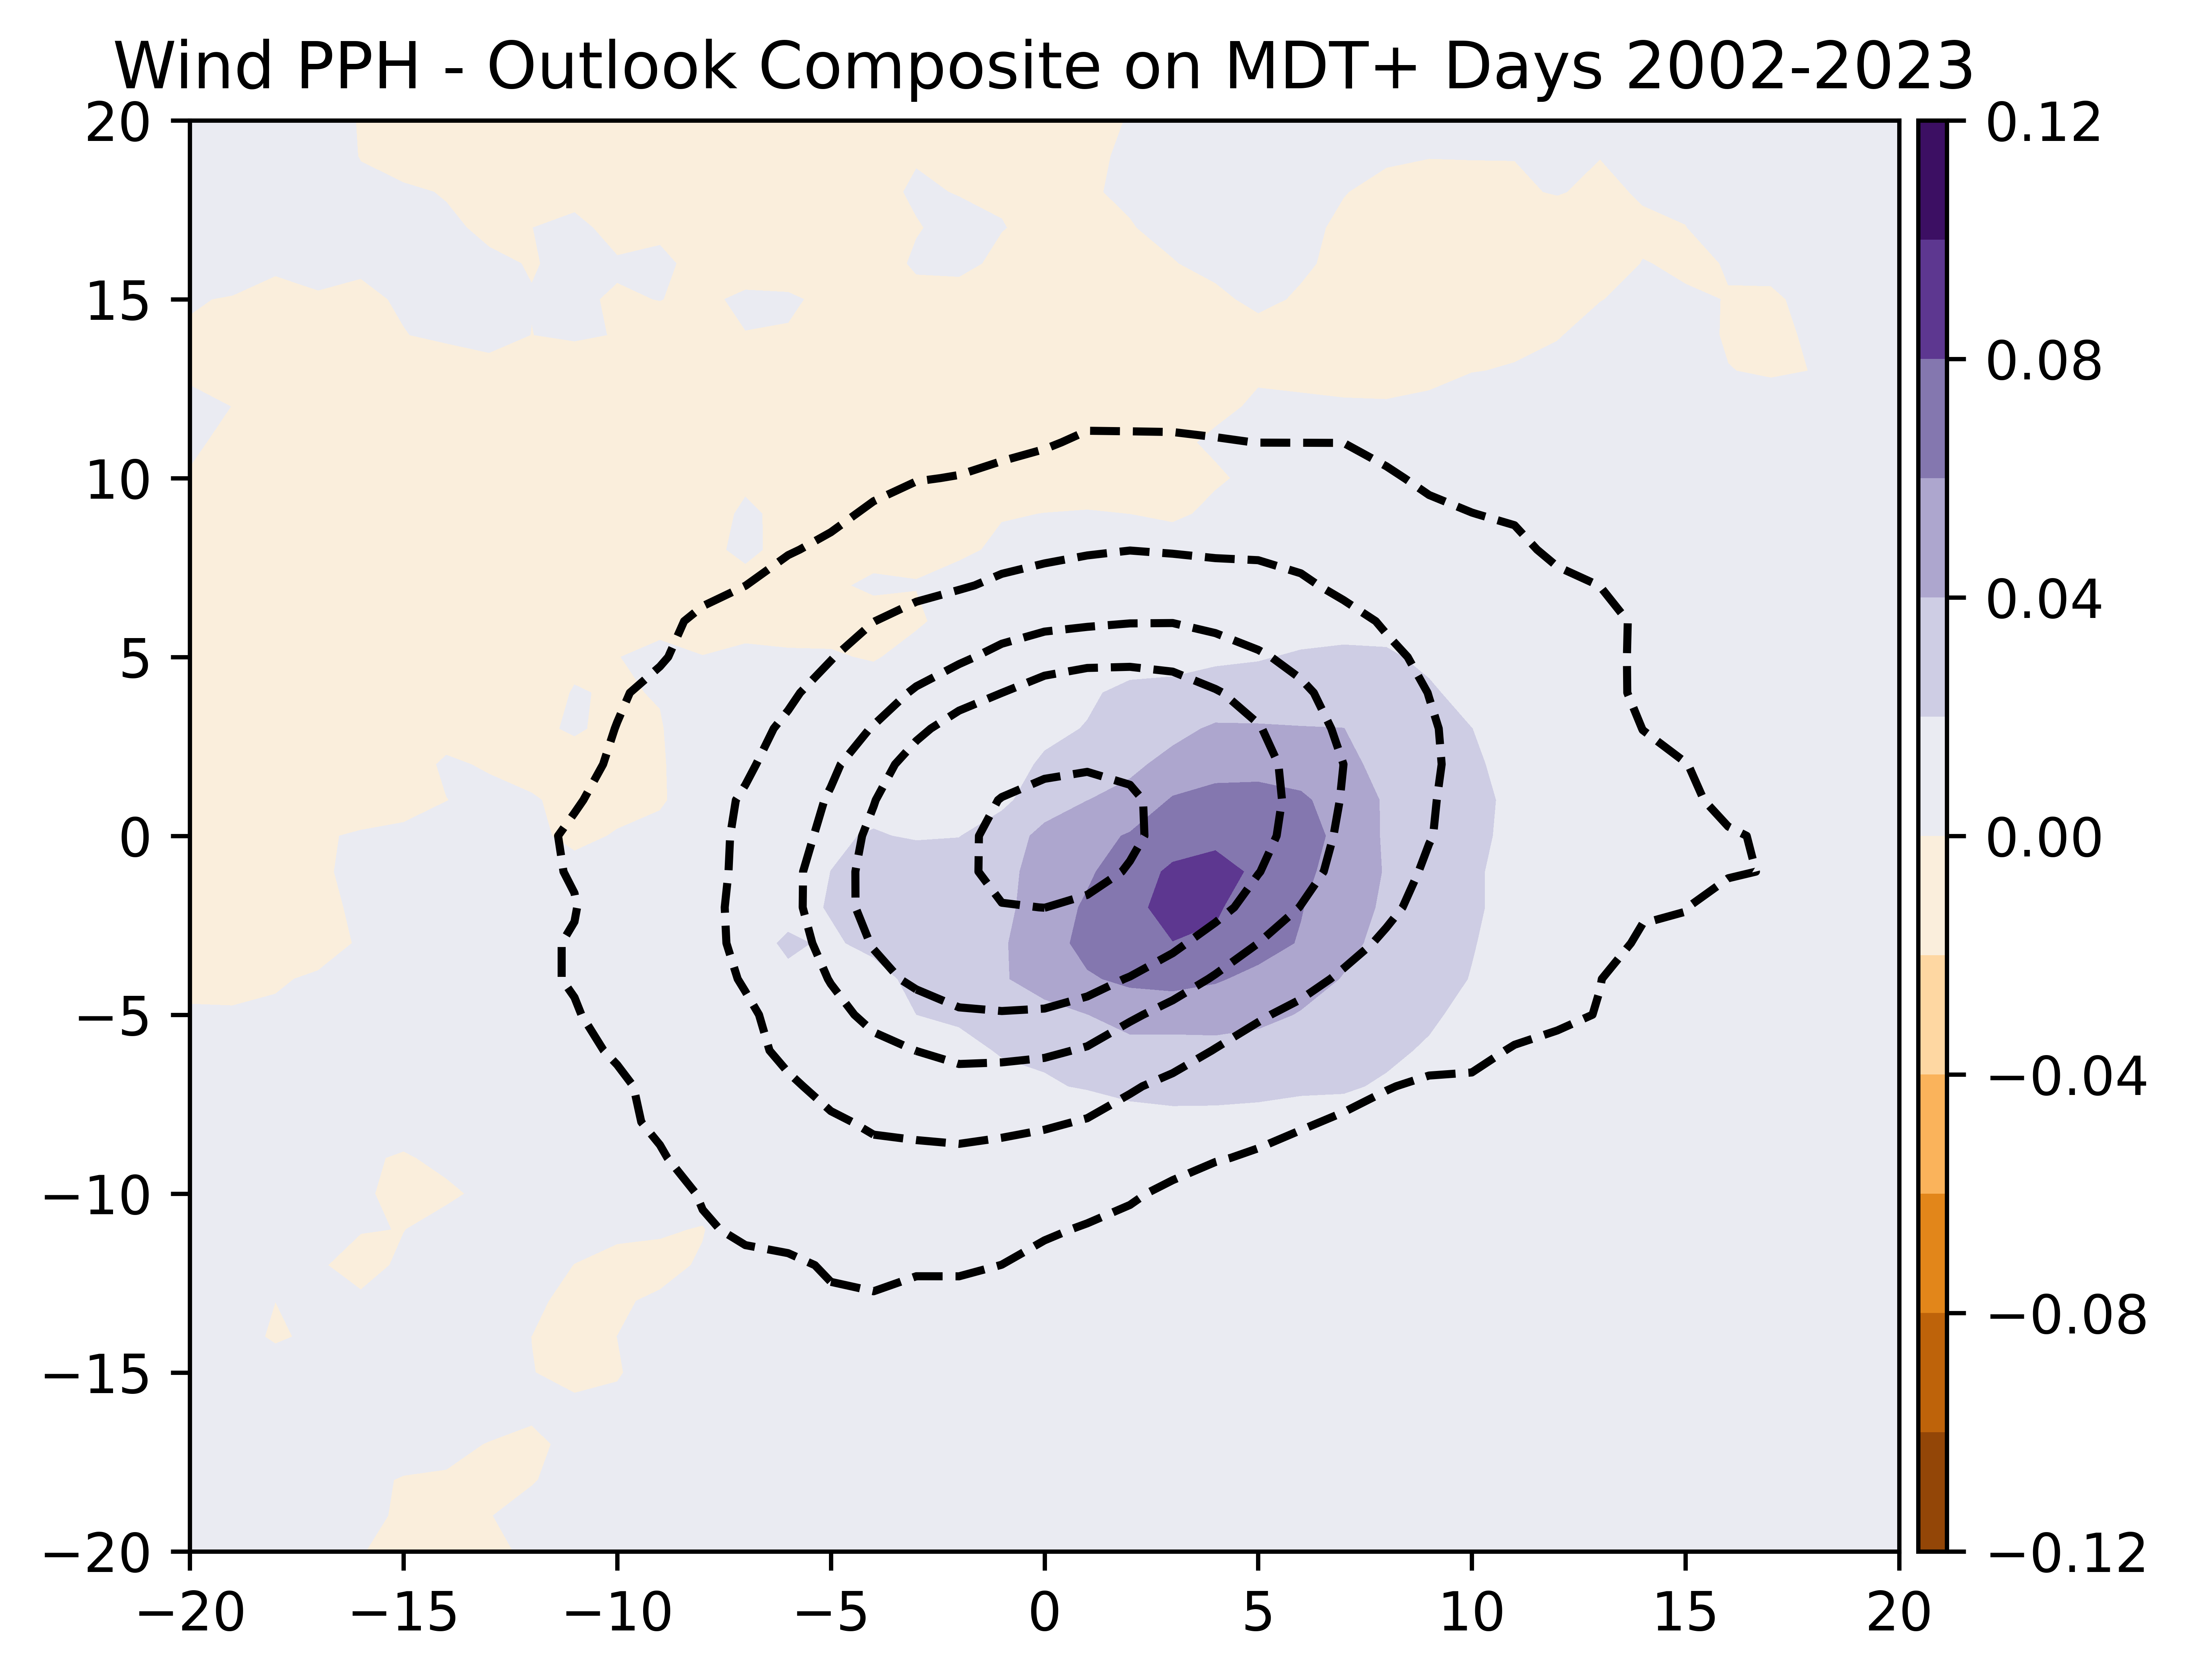

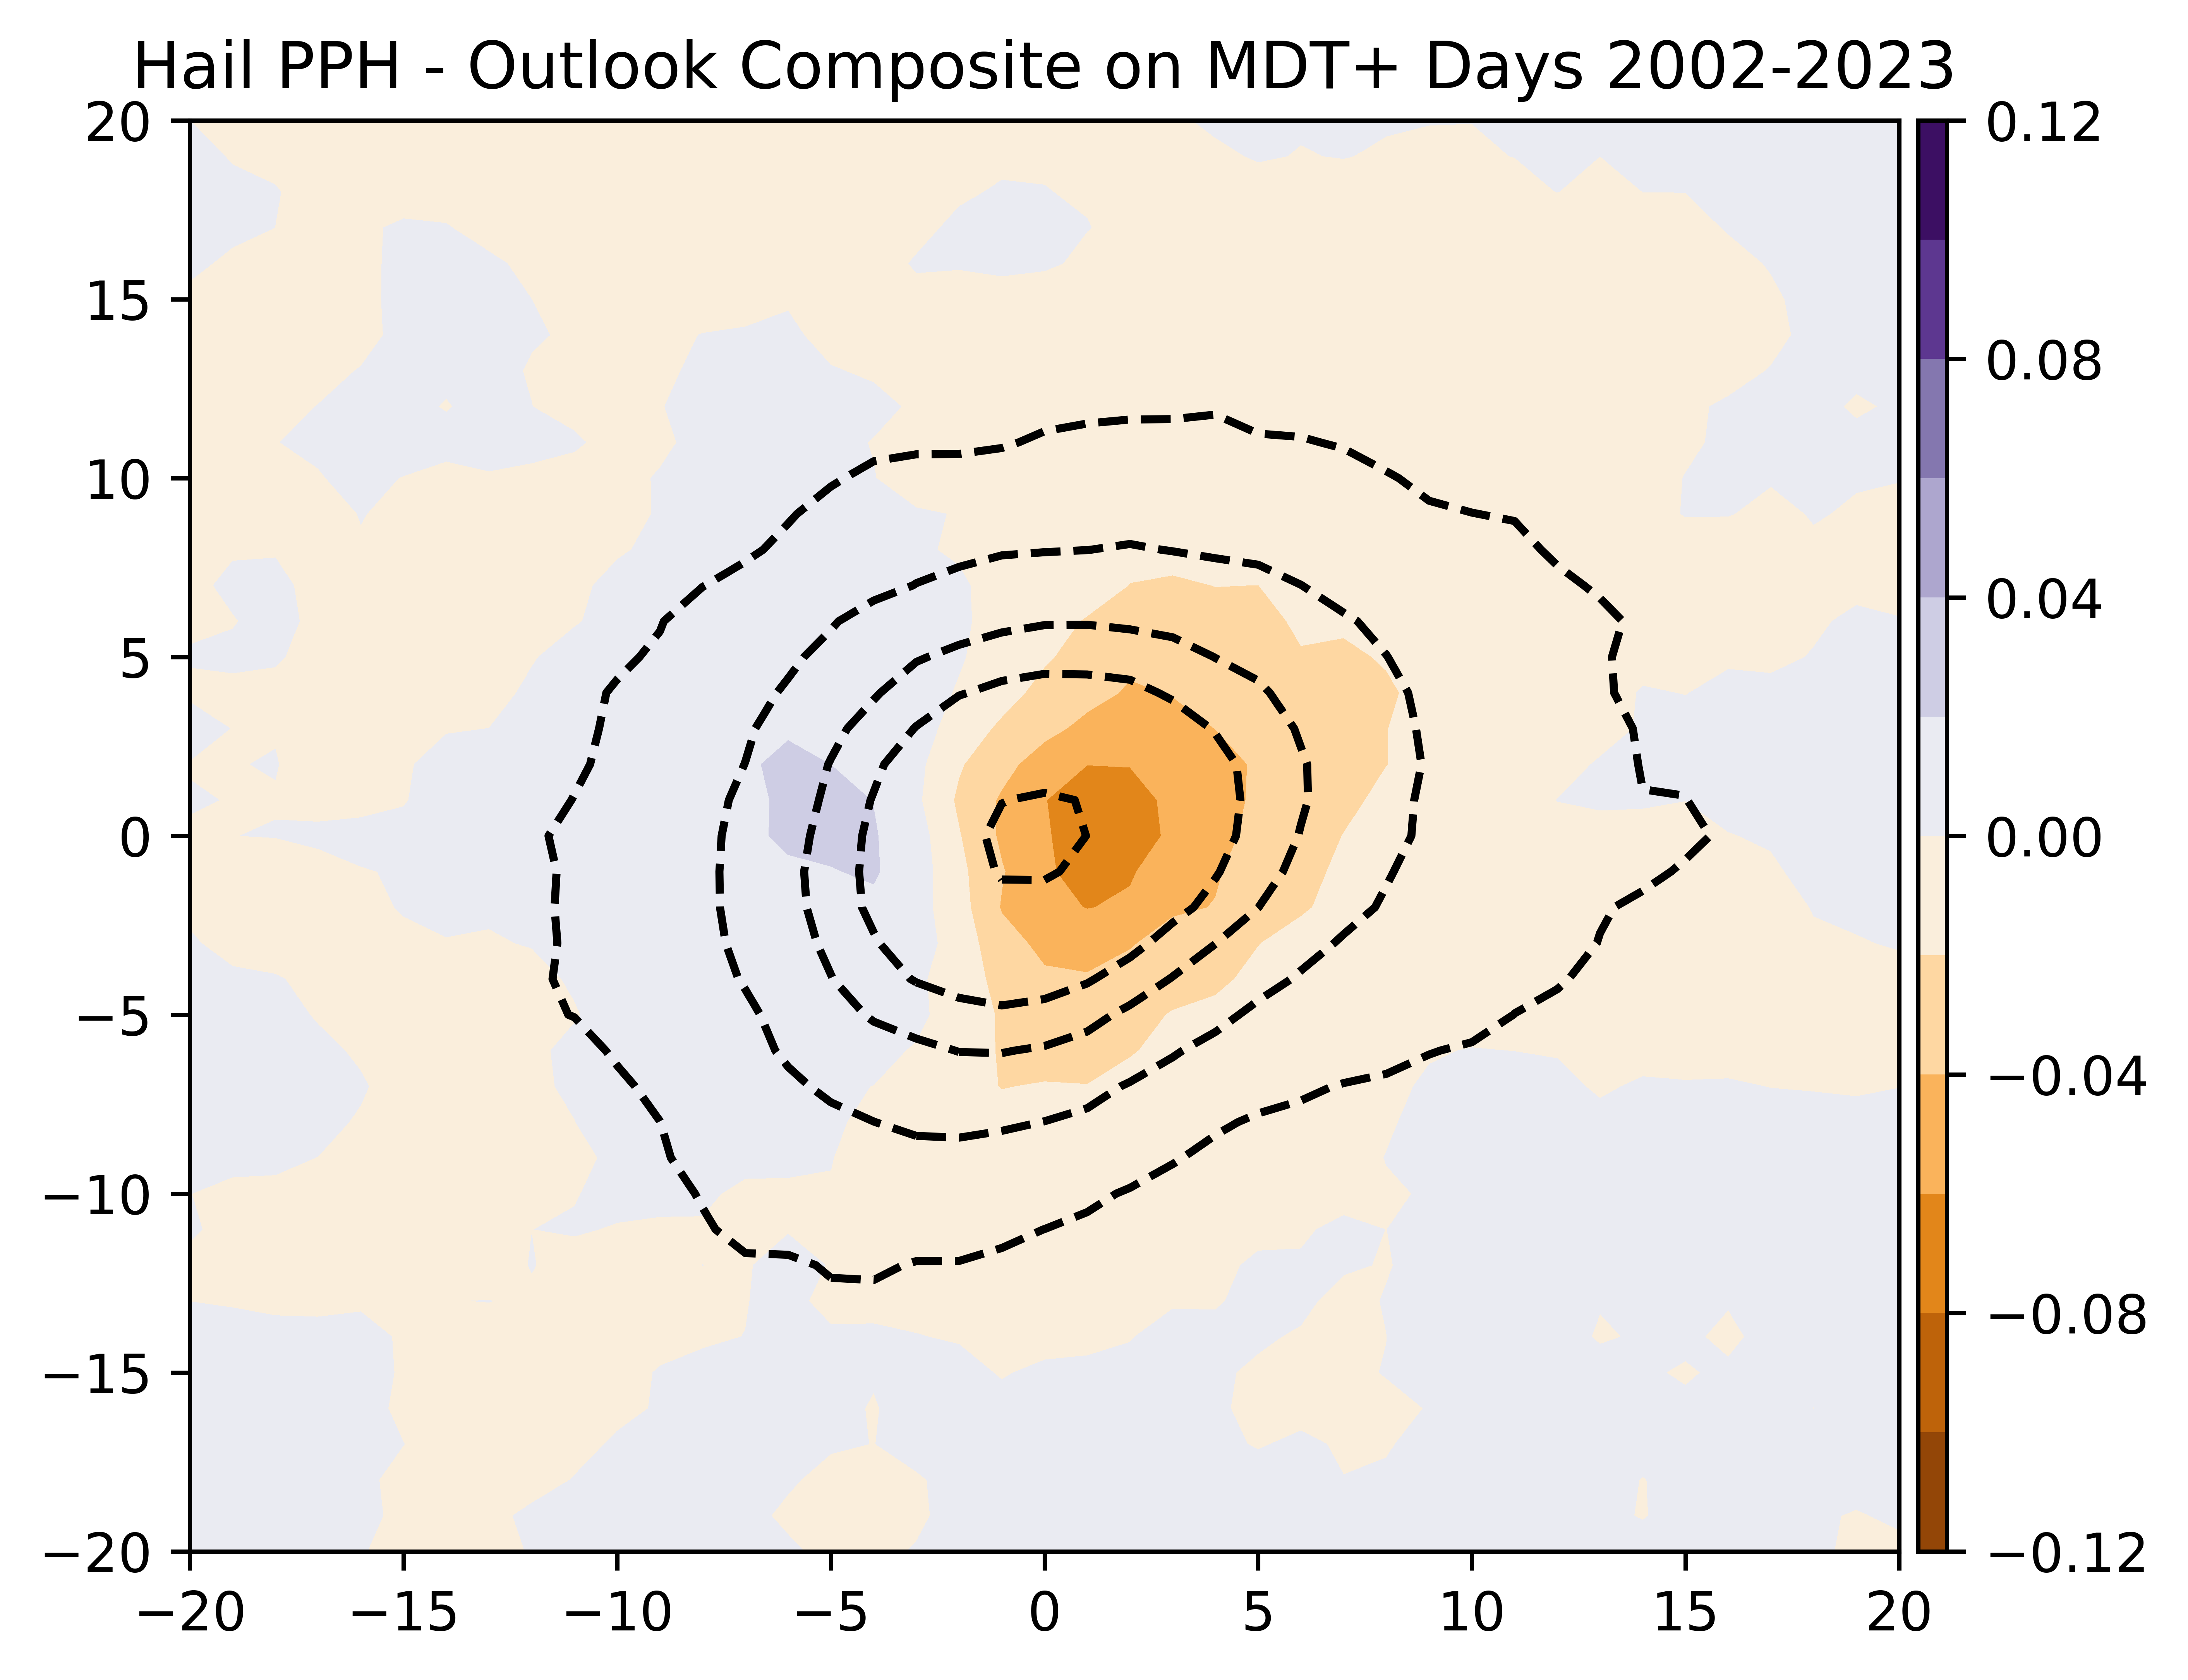

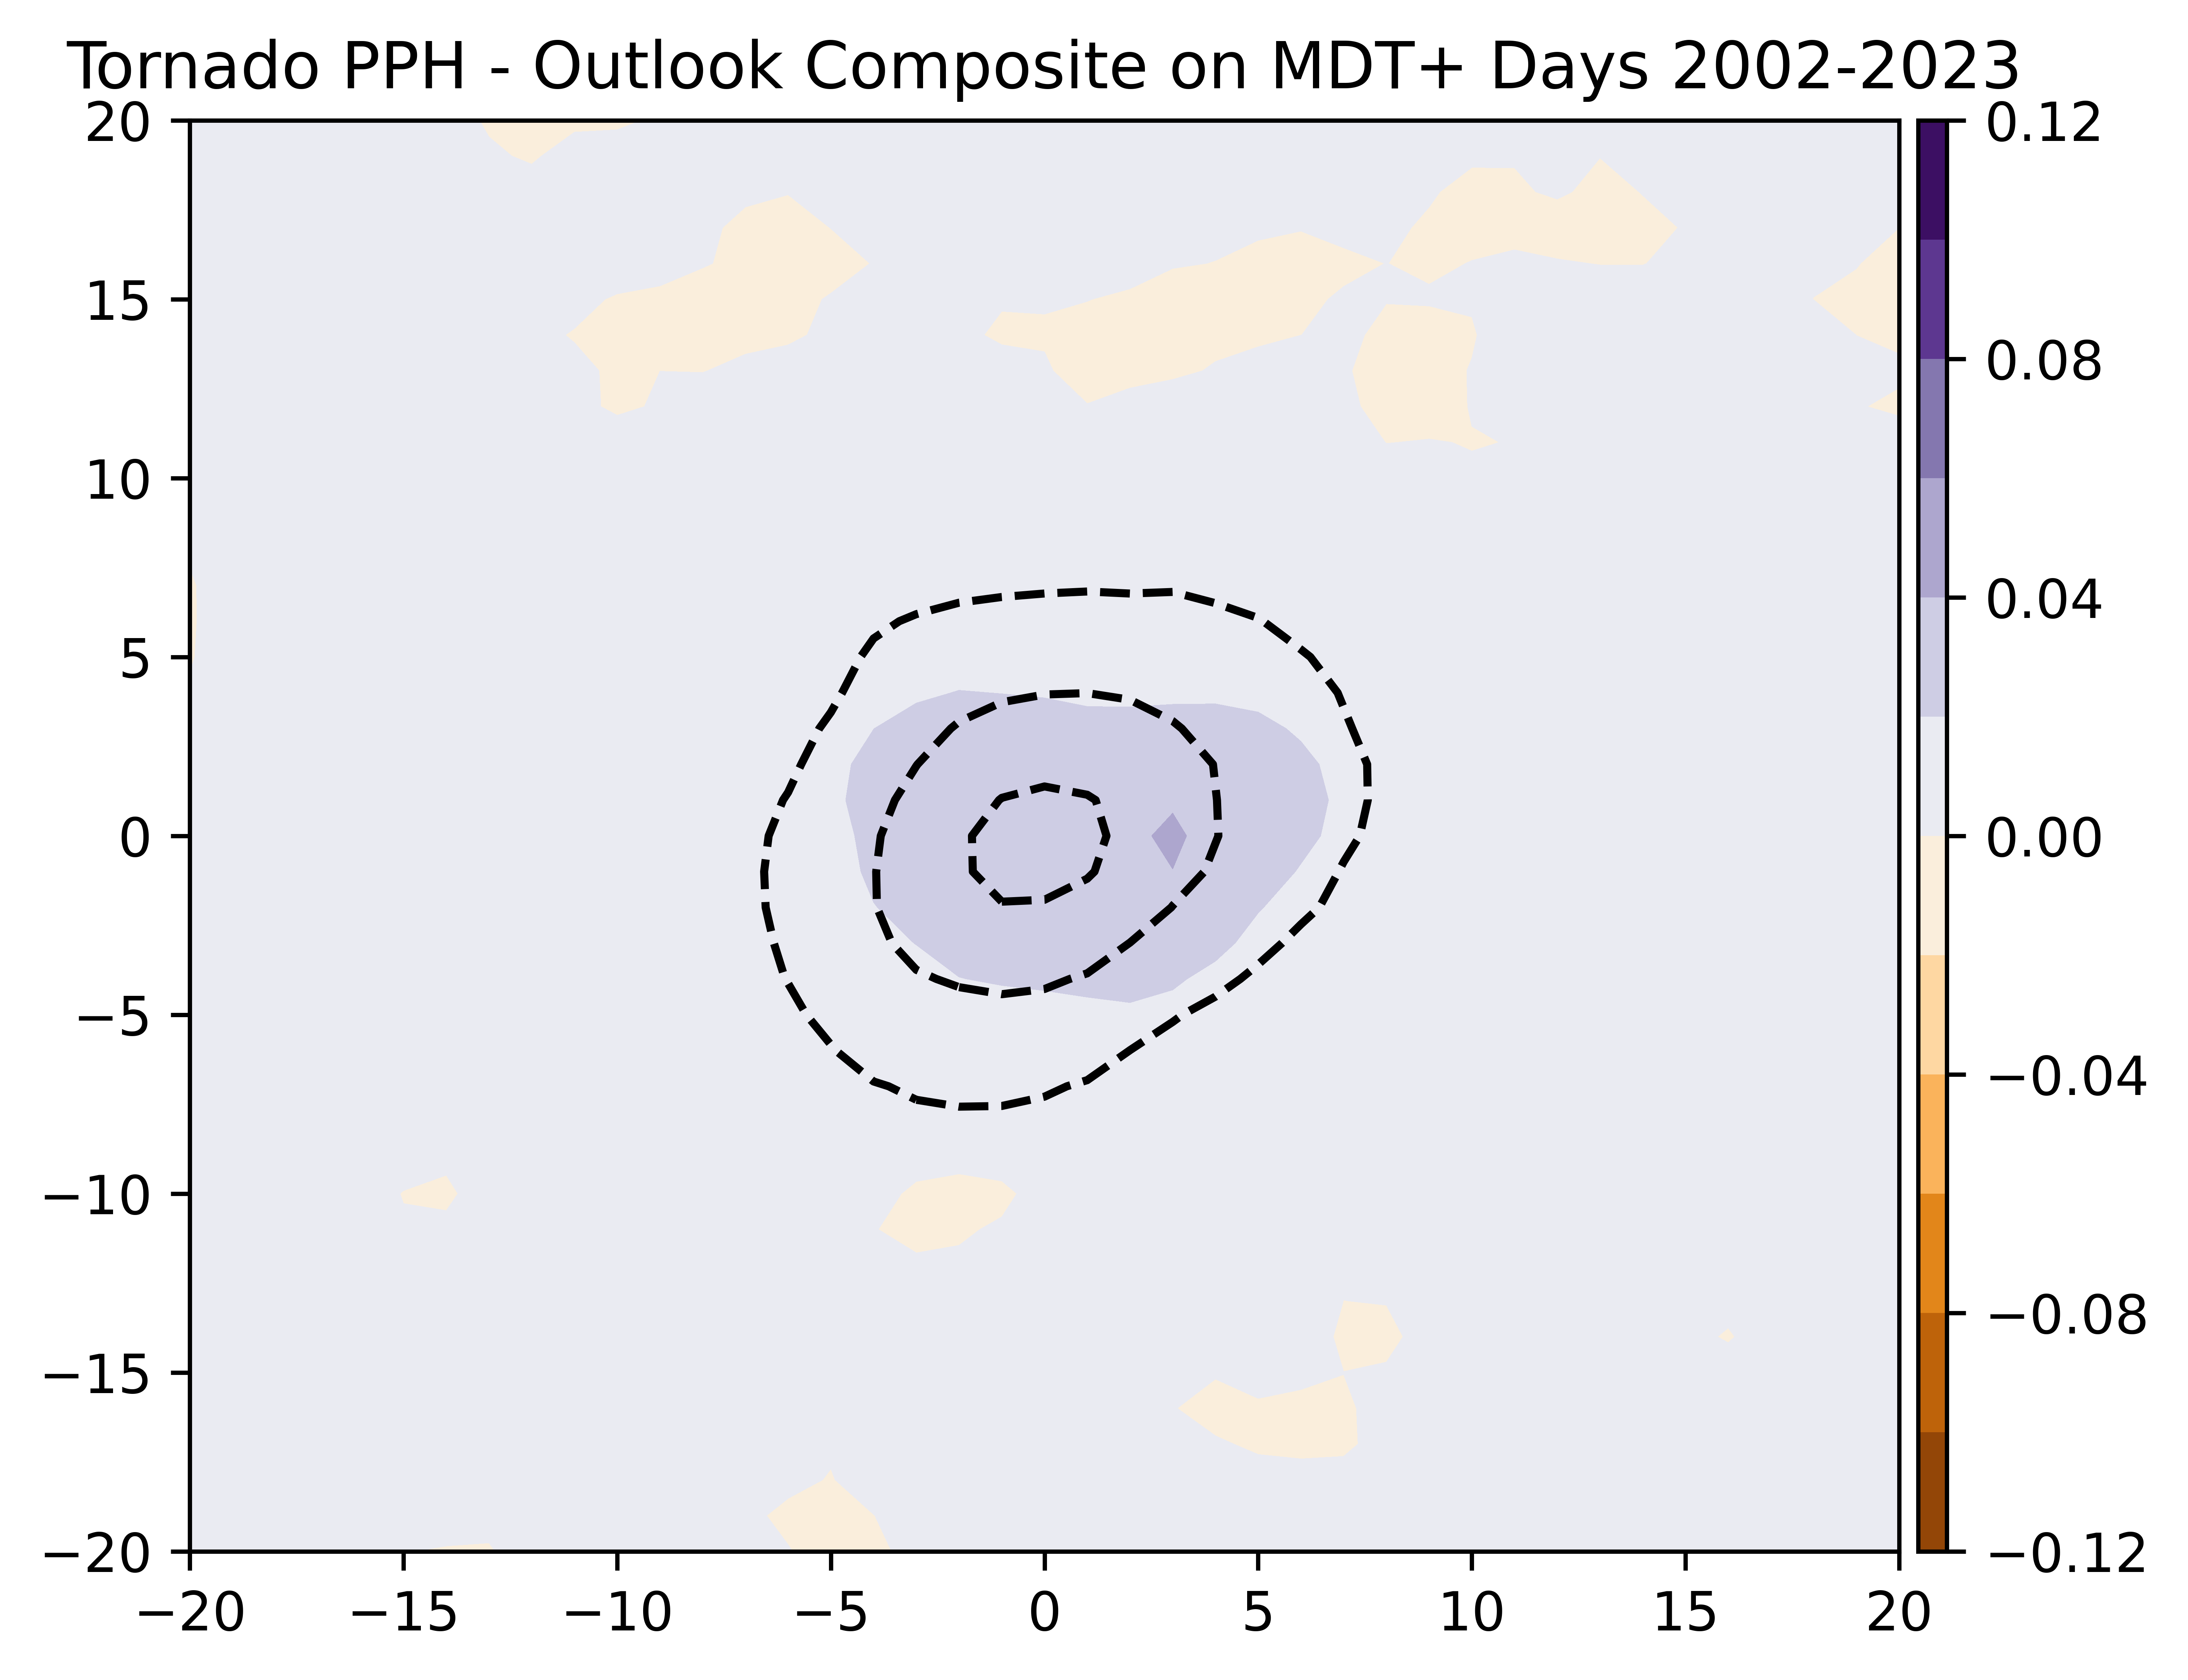

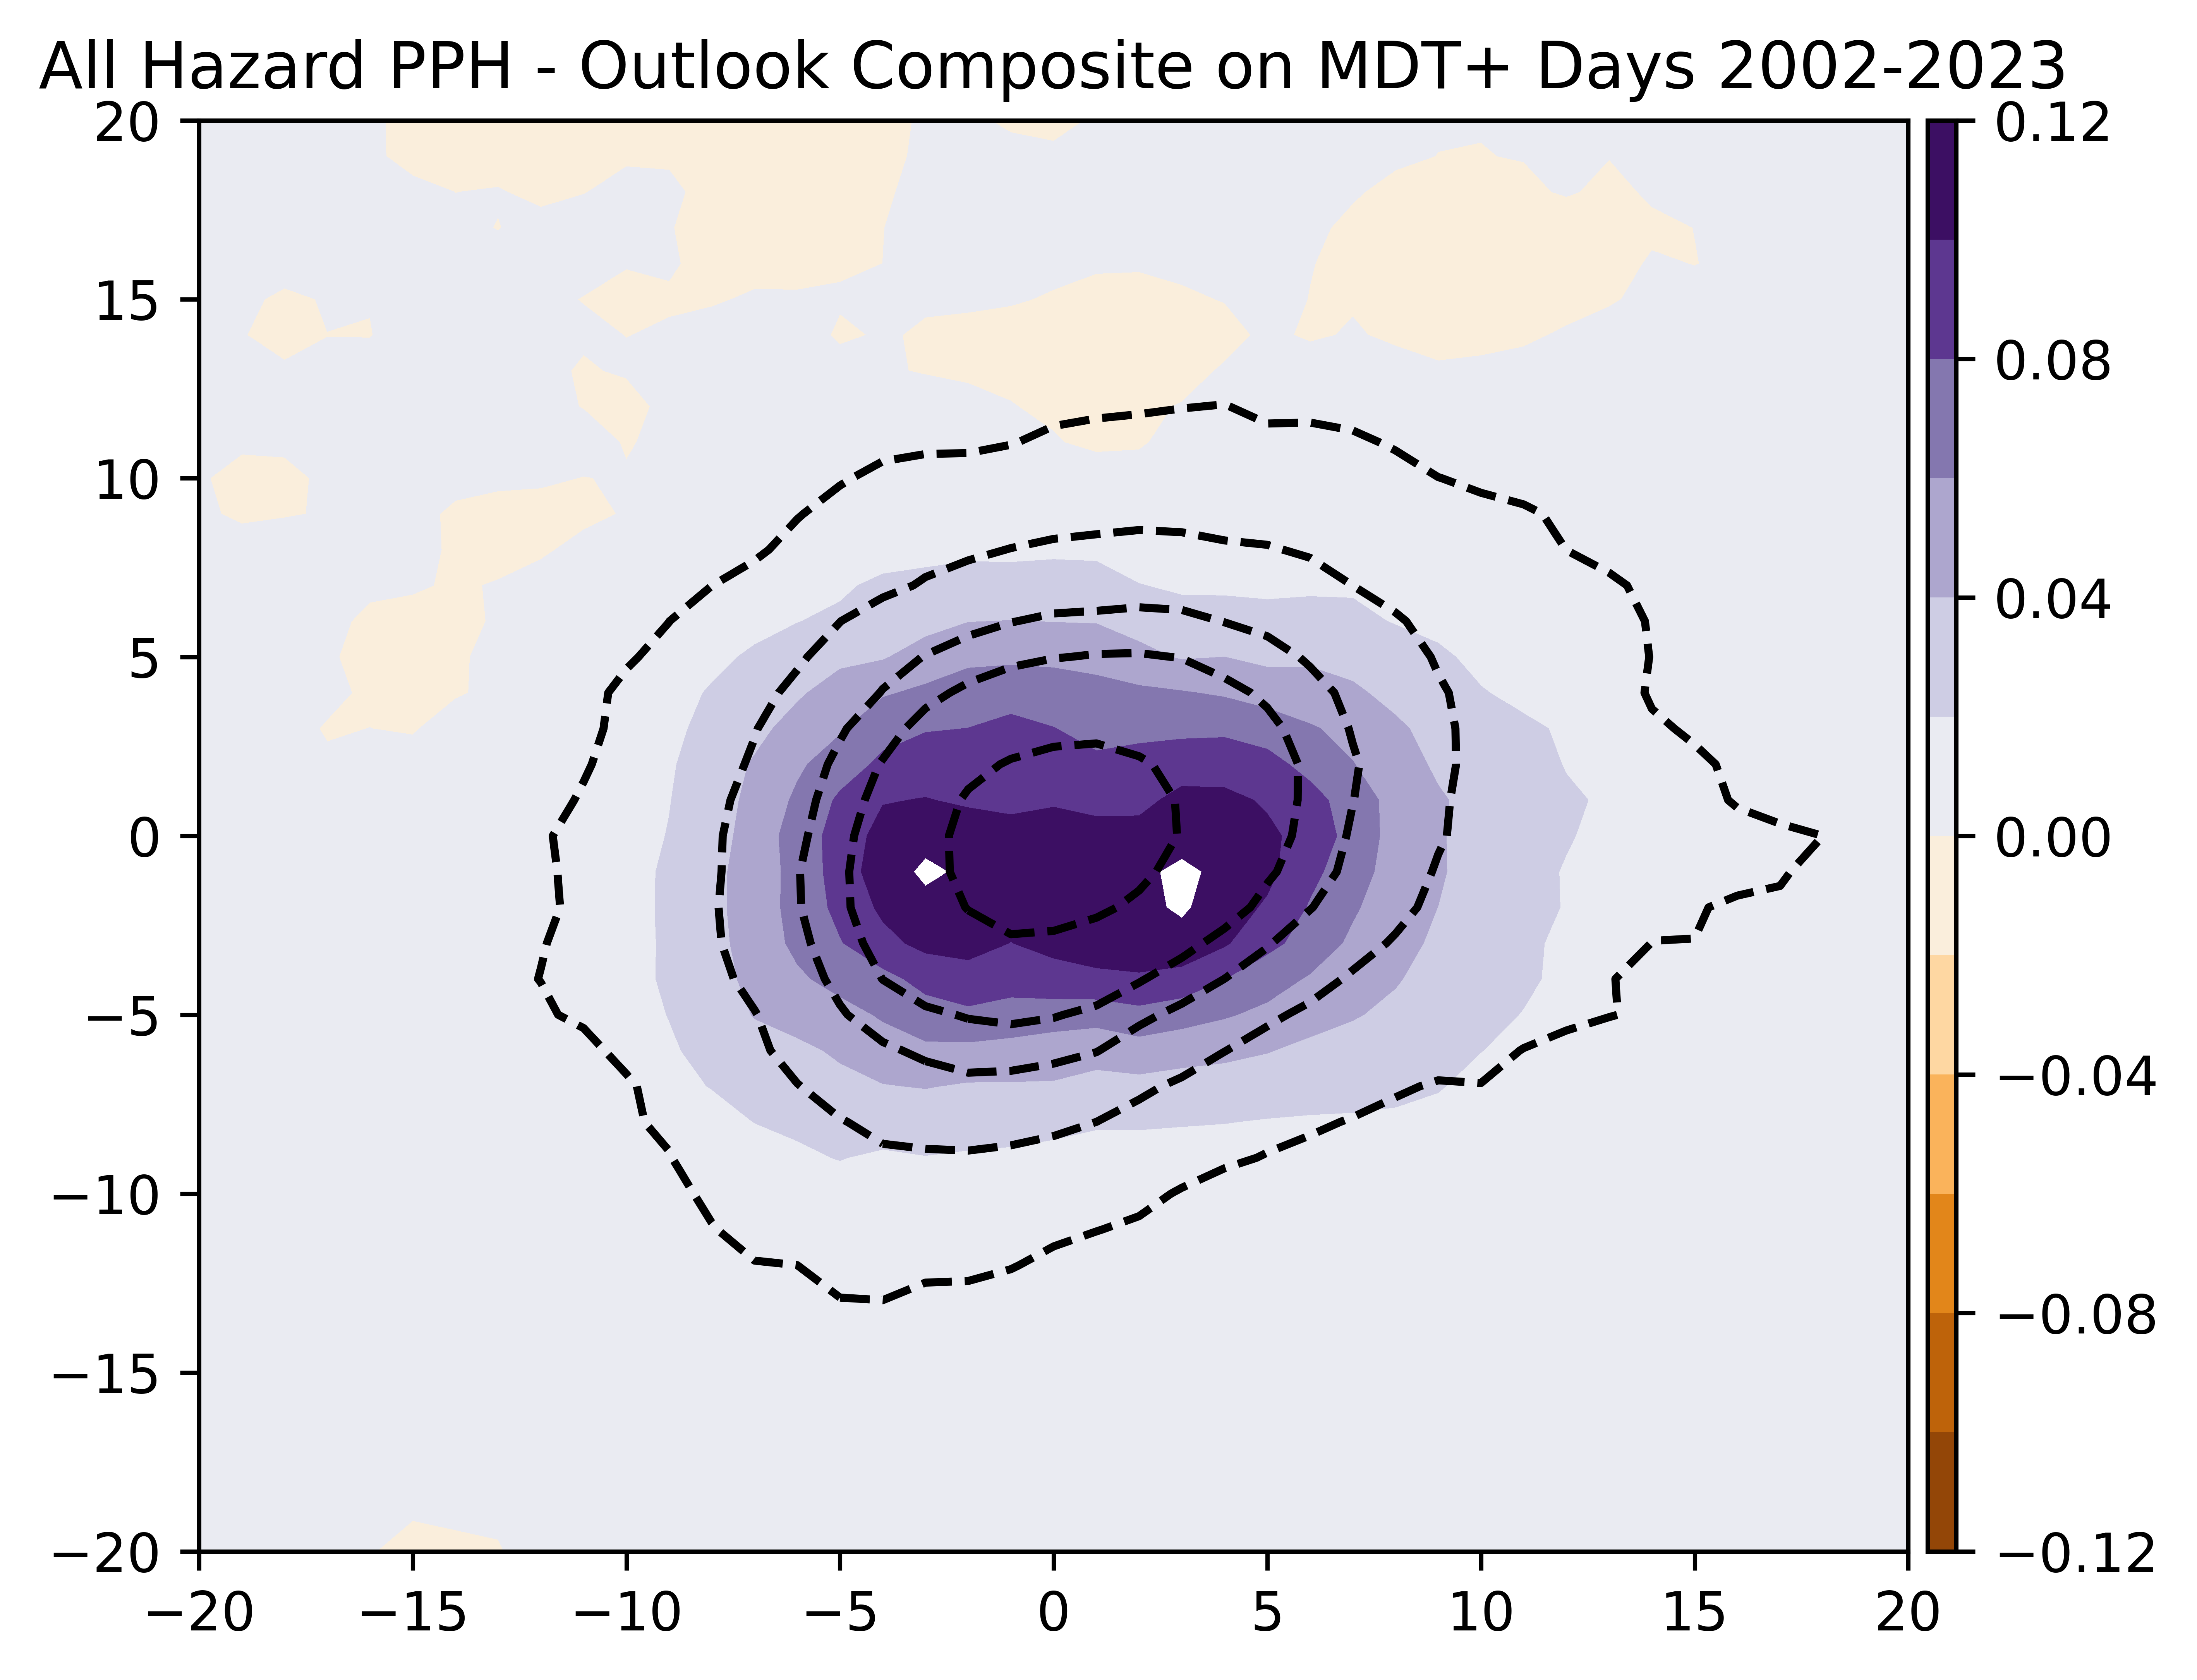

: 

Shift Distributions

In [33]:
ds.sel(time = '201104270000').load()

<xarray.Dataset>
Dimensions:      (x: 152, y: 99, hazard: 4)
Coordinates:
  * x            (x) float64 -80.0 -79.0 -78.0 -77.0 ... 68.0 69.0 70.0 71.0
  * y            (y) float64 -44.0 -43.0 -42.0 -41.0 ... 51.0 52.0 53.0 54.0
  * hazard       (hazard) object 'Wind' 'Hail' 'Tornado' 'All Hazard'
    time         <U12 '201104270000'
Data variables: (12/23)
    lat          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    lon          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    x_flow       (y, x, hazard) float64 nan nan nan nan nan ... nan nan nan nan
    y_flow       (y, x, hazard) float64 nan nan nan nan nan ... nan nan nan nan
    end_lon      (y, x, hazard) float64 nan nan nan nan nan ... nan nan nan nan
    end_lat      (y, x, hazard) float64 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    e_shift_s    (hazard) float64 3.116e+05 1.5e+05 1.165e+05 1.225e+05
    n_shift_s    (hazard) float64 2.461e+05 1.374e+05 1.121e+04 7.547e+04
    total_div_s  (hazard) float64 0.5059 0.6156 0.7457 0.636
    e_shift_w    (hazard) float64 3.067e+05 -1.715e+04 3.985e+03 1.077e+04
    n_shift_w    (hazard) float64 2.091e+05 8.915e+04 -4.24e+04 -2.274e+04
    total_div_w  (hazard) float64 0.7096 0.8611 0.8107 0.4939
Attributes:
    description:  Displacements from gridded day 1 probabilistic outlooks to ...
    grid:         80-km NCEP 211

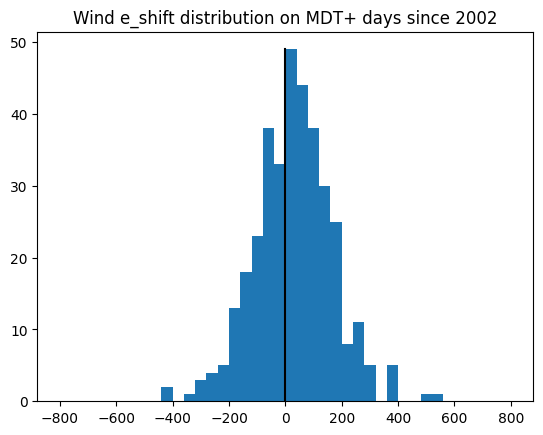

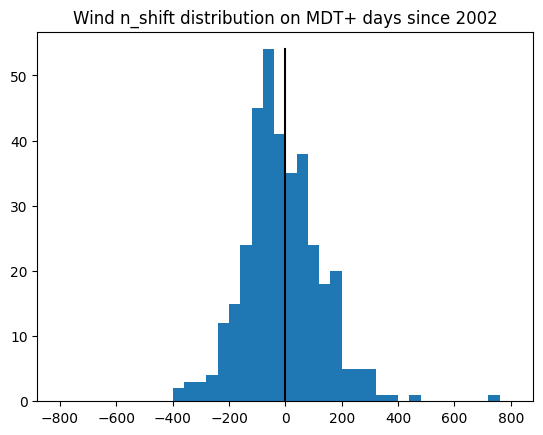

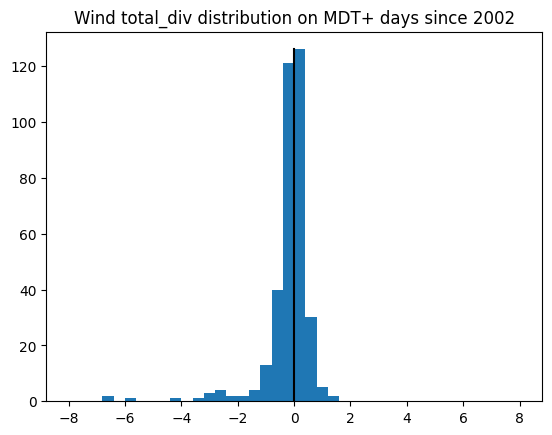

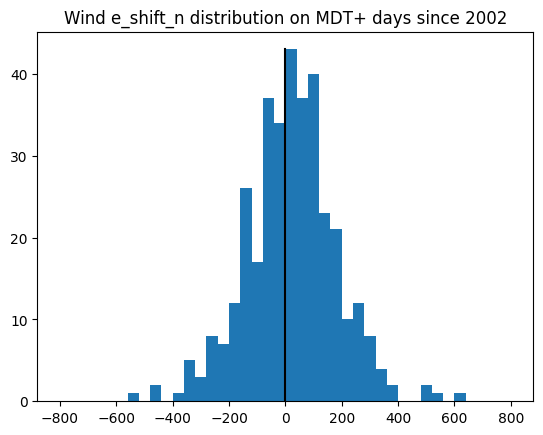

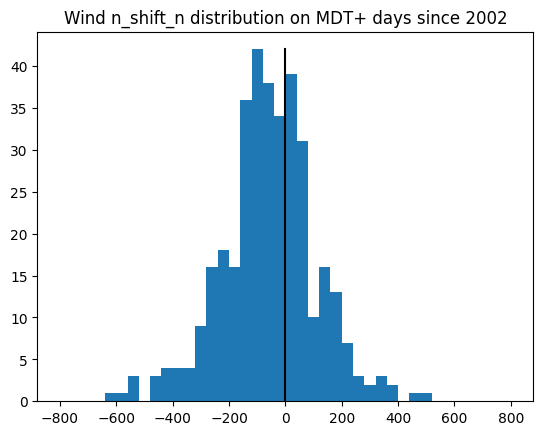

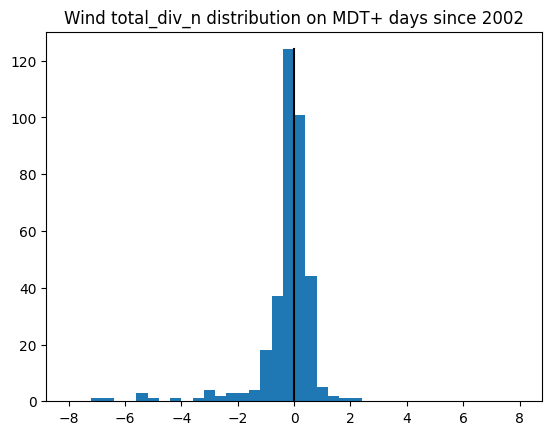

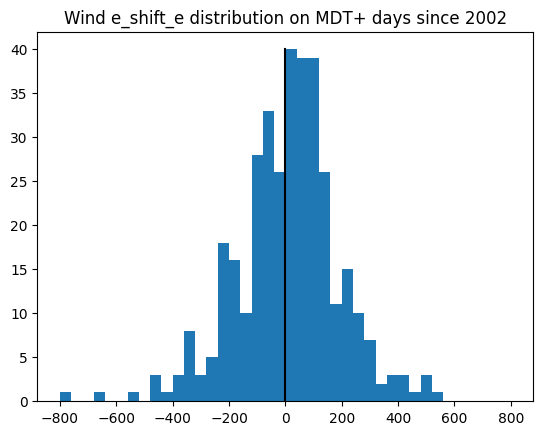

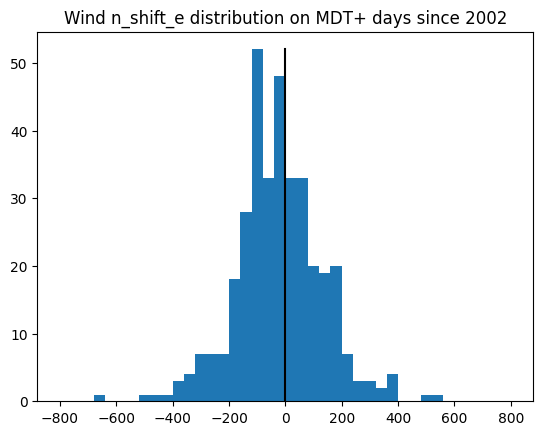

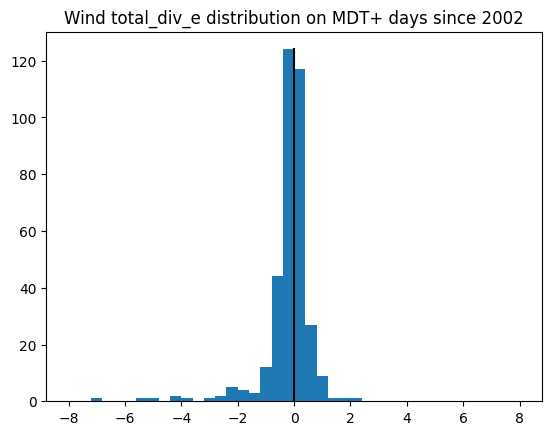

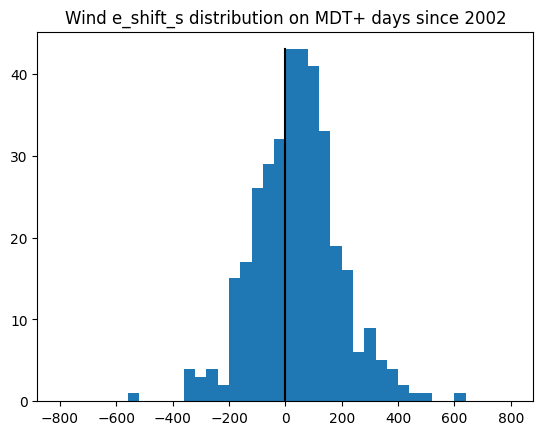

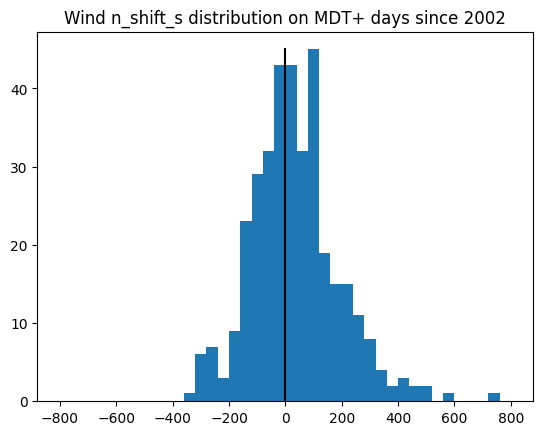

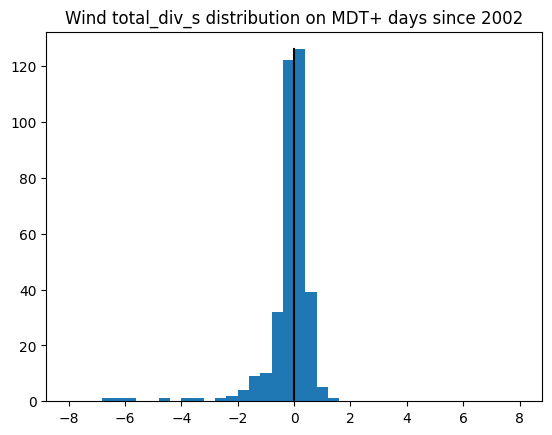

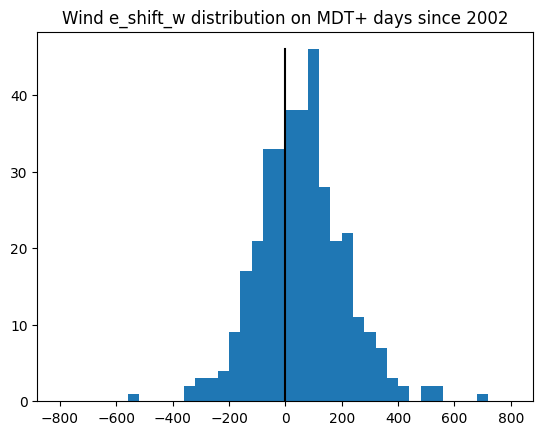

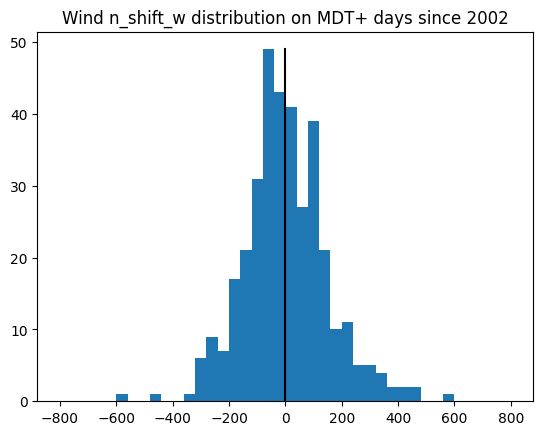

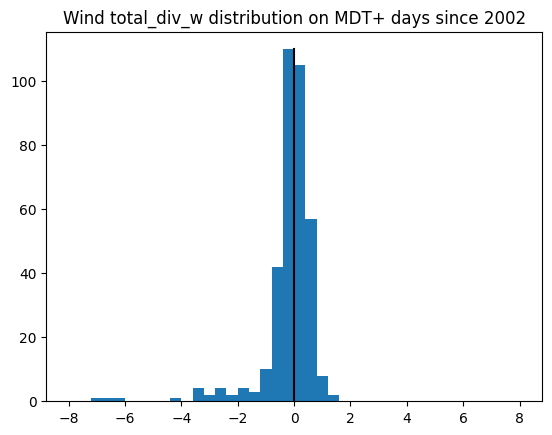

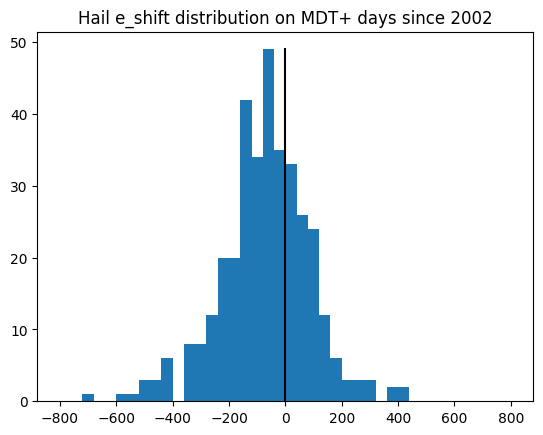

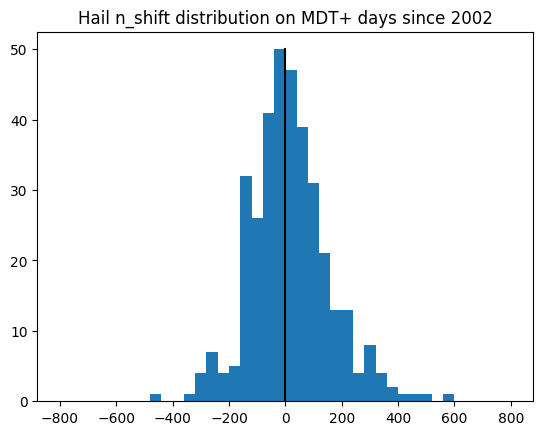

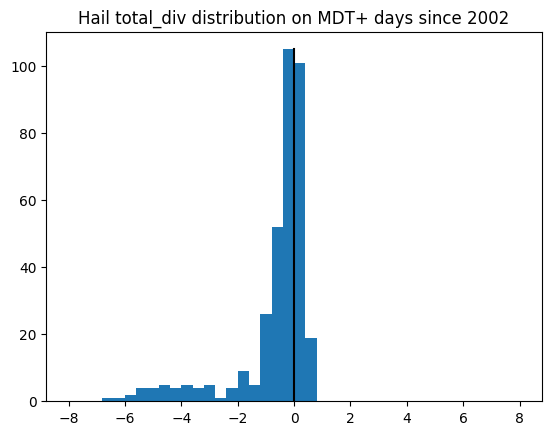

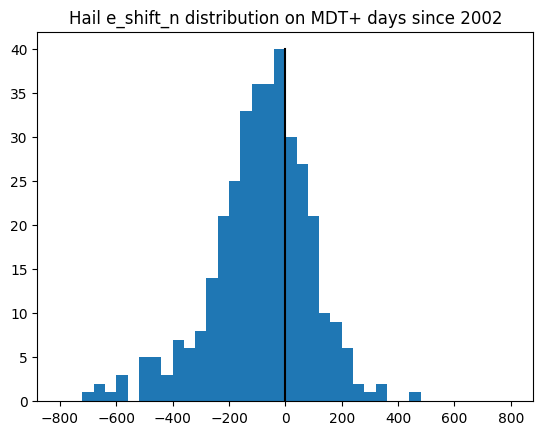

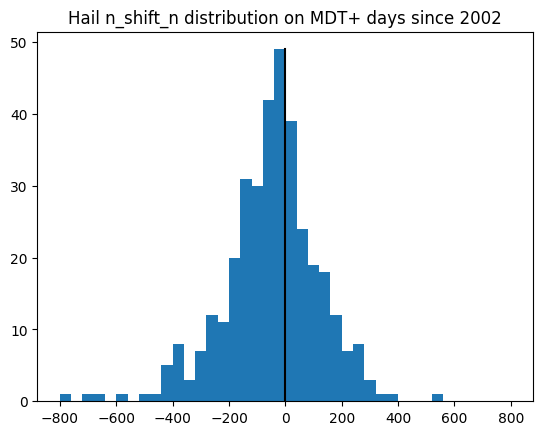

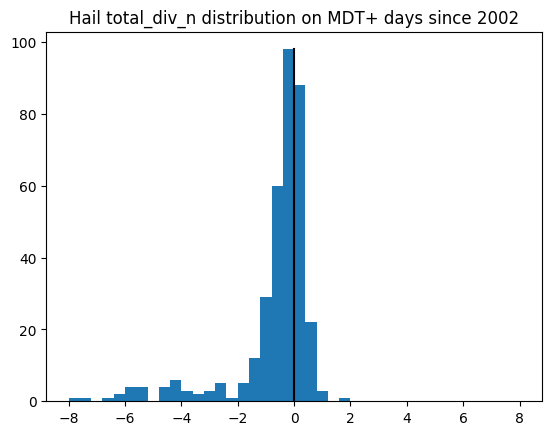

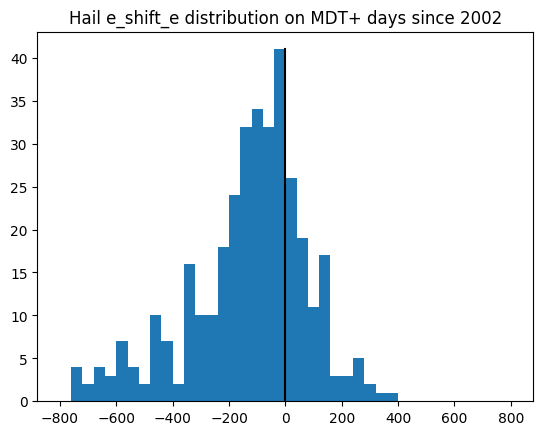

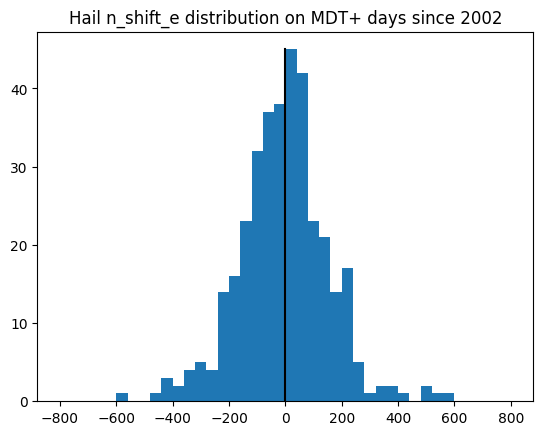

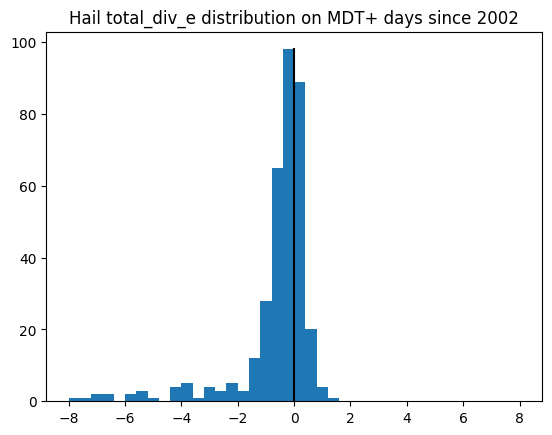

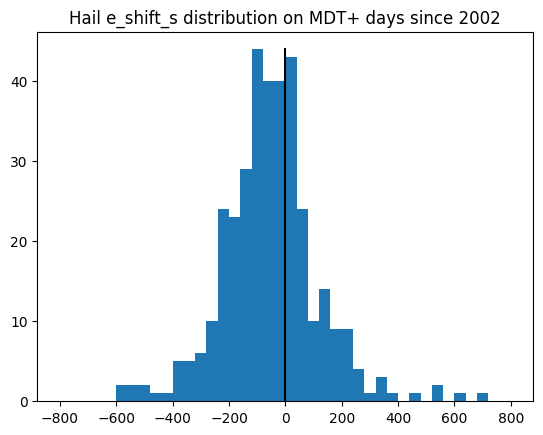

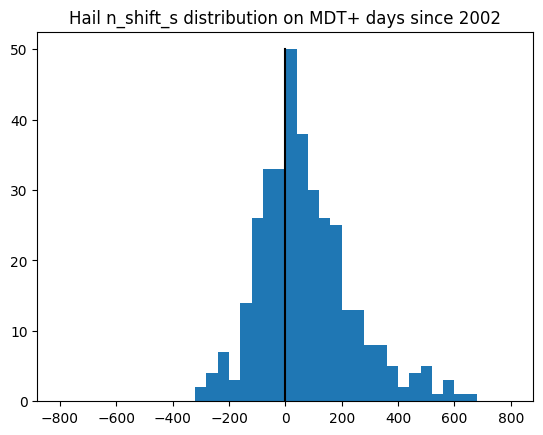

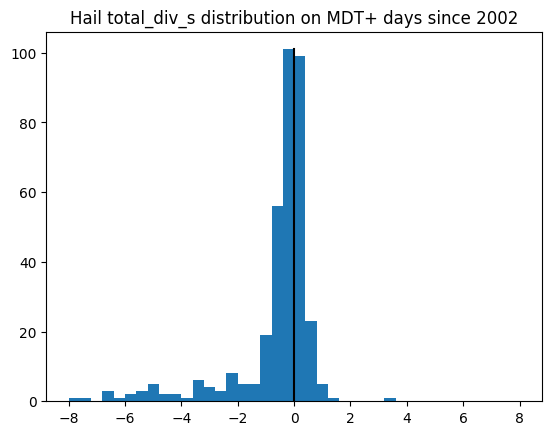

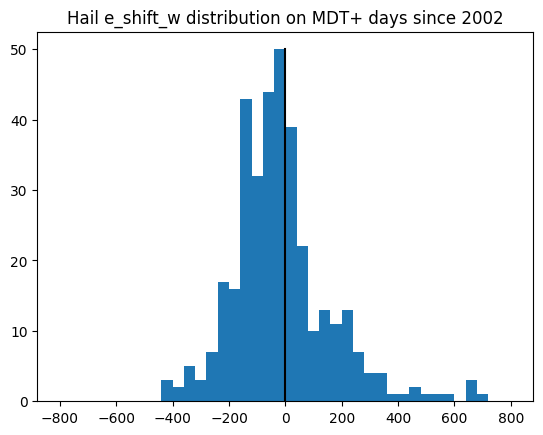

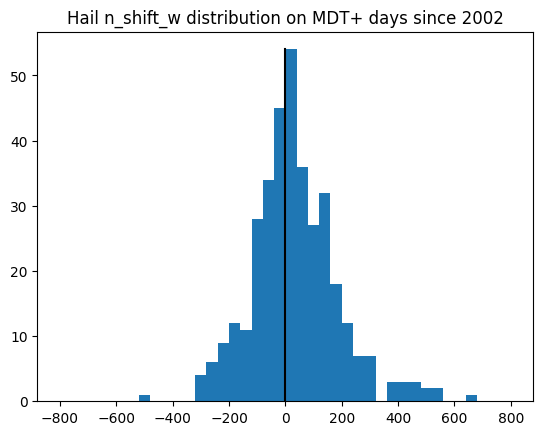

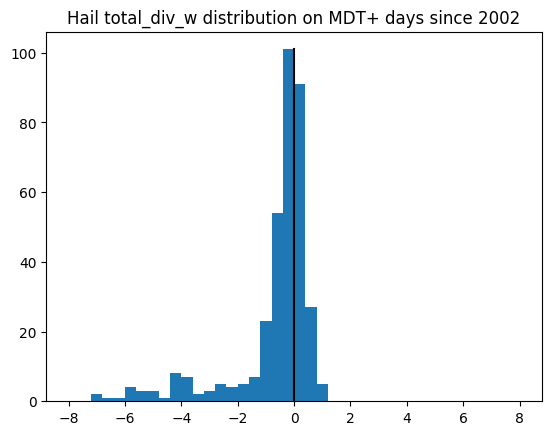

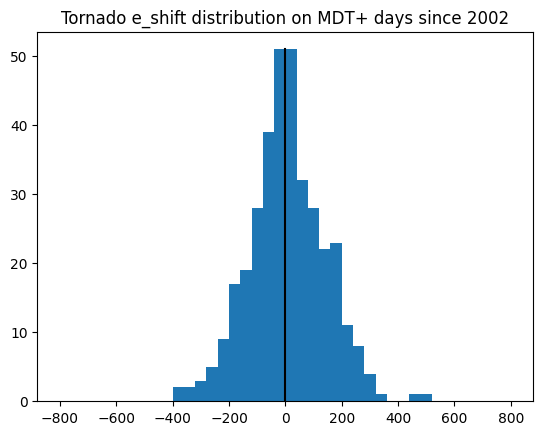

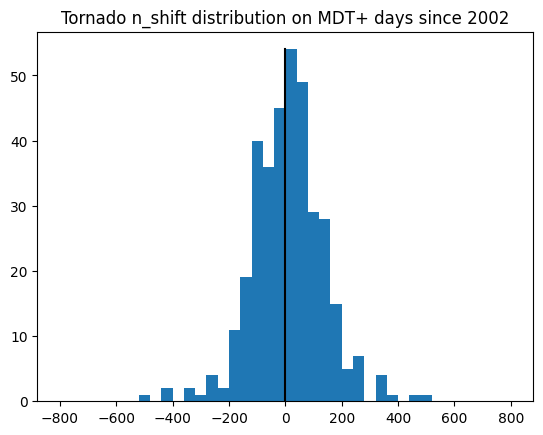

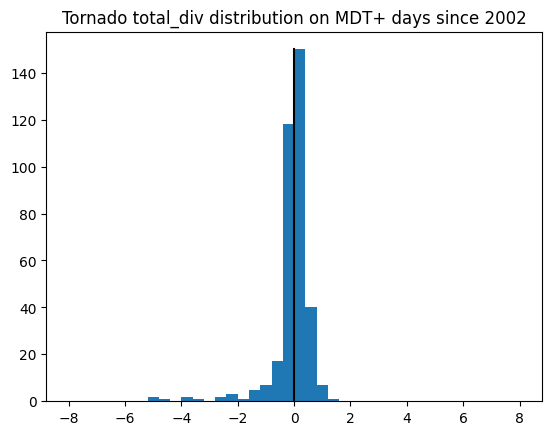

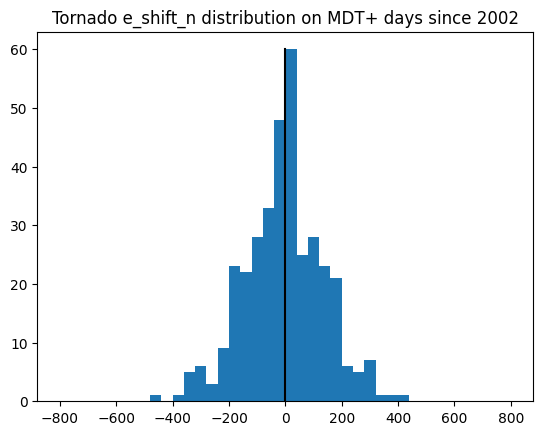

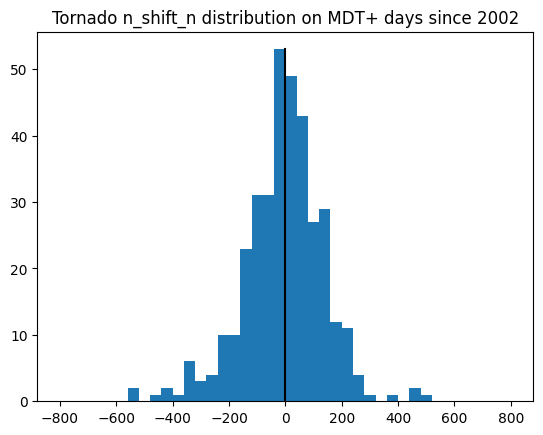

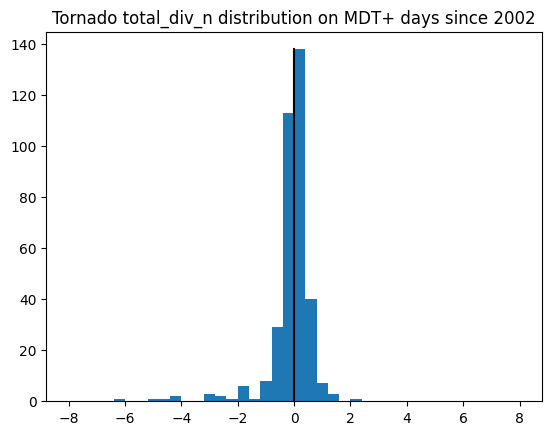

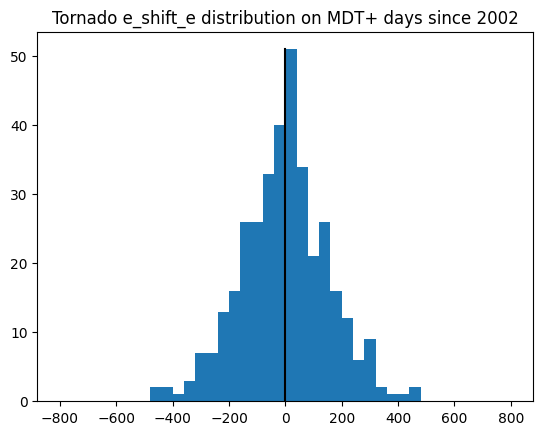

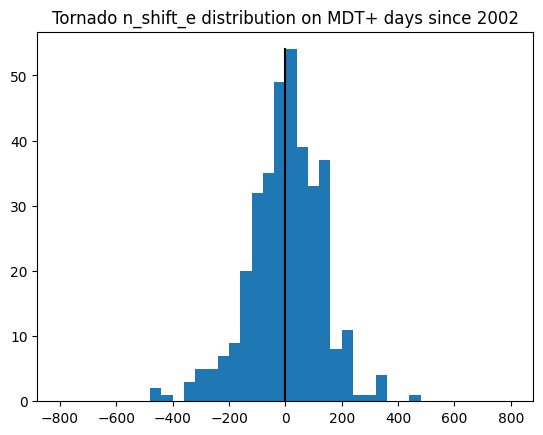

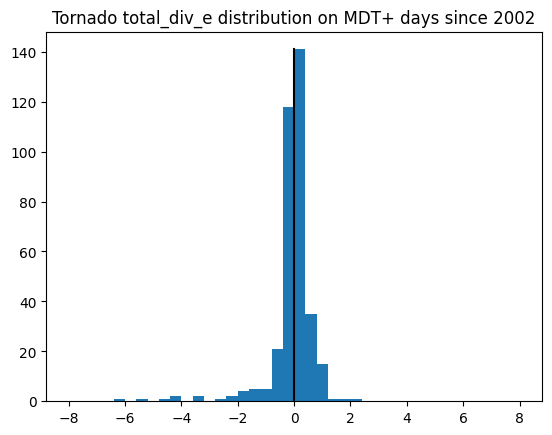

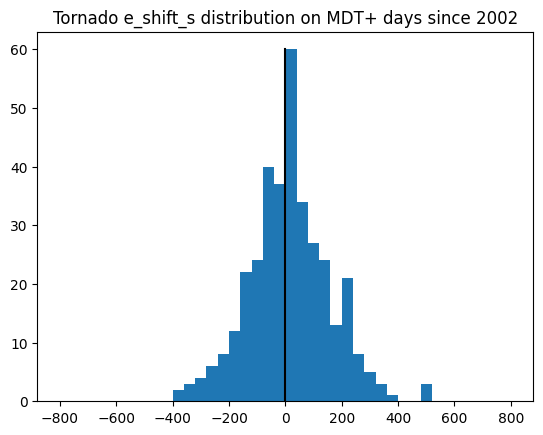

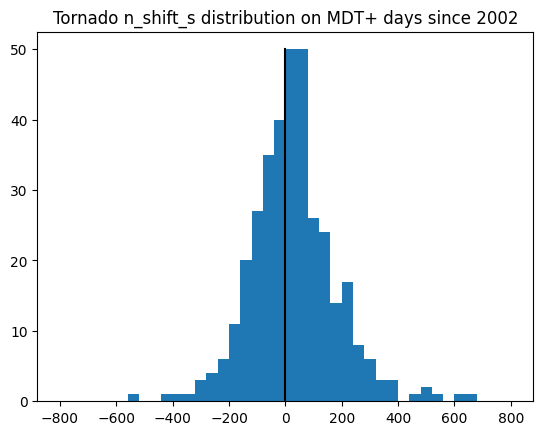

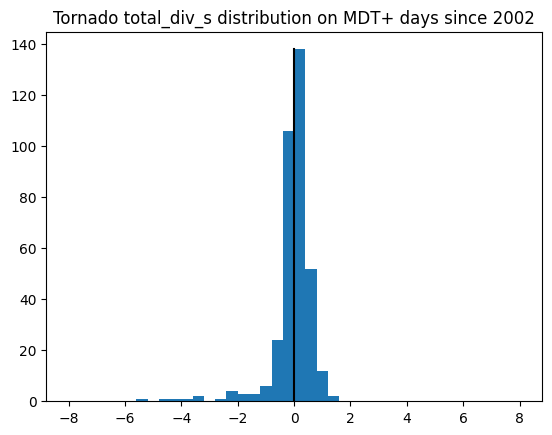

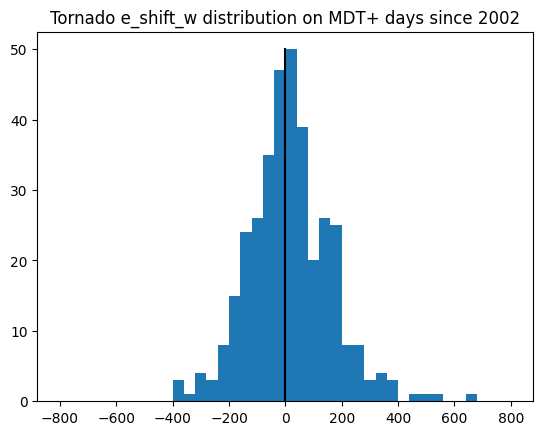

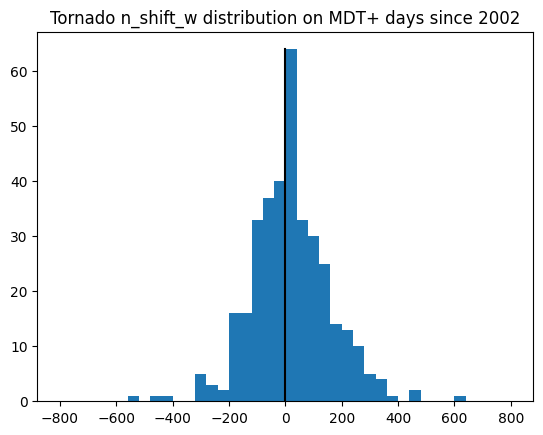

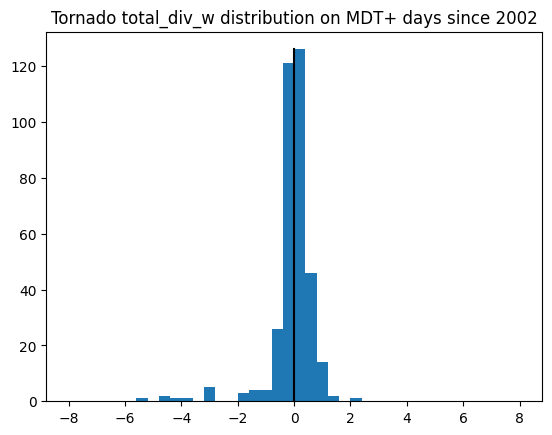

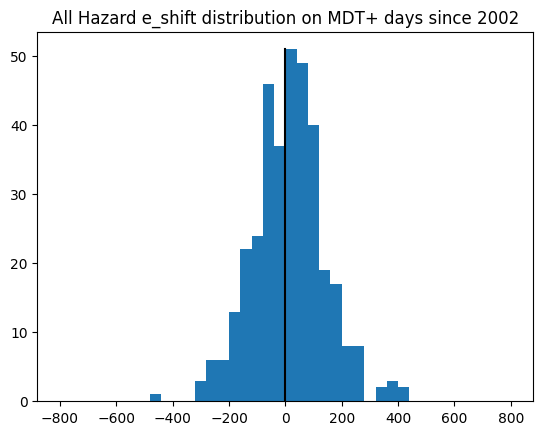

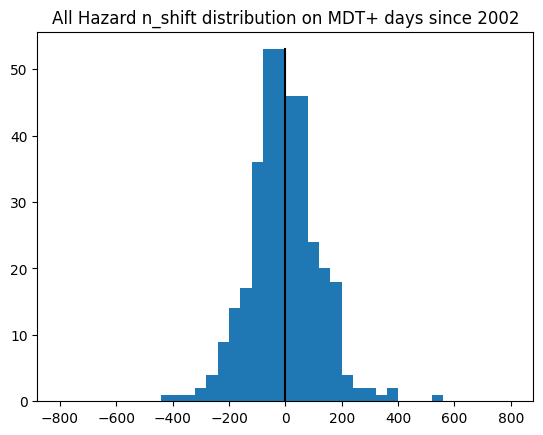

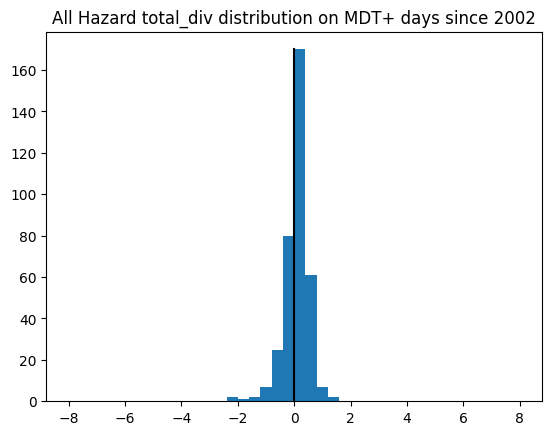

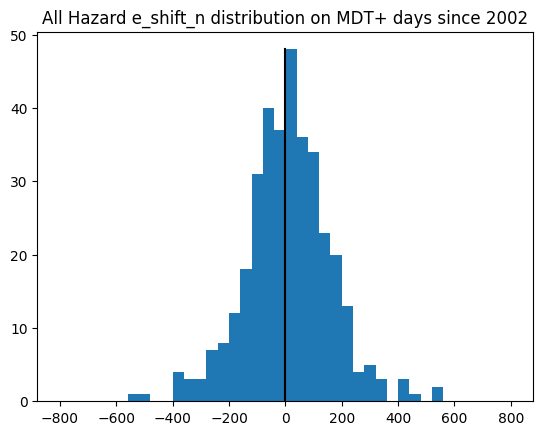

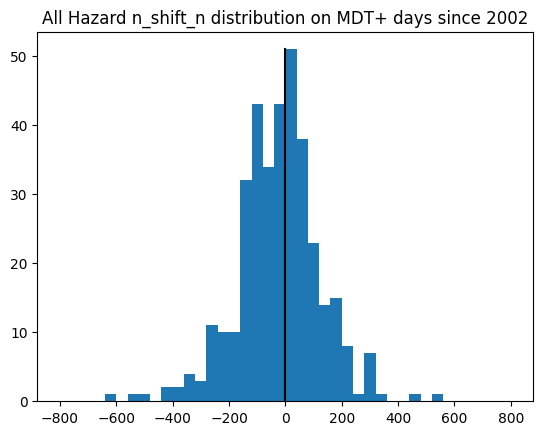

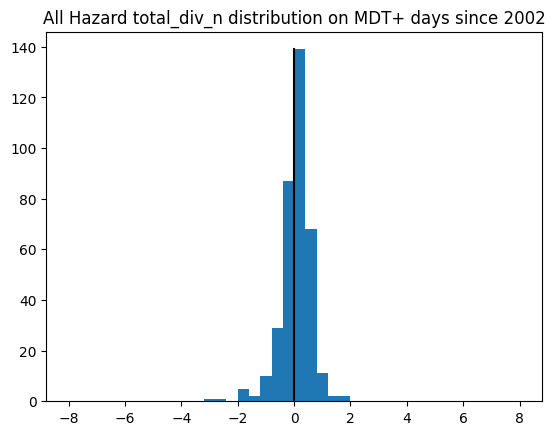

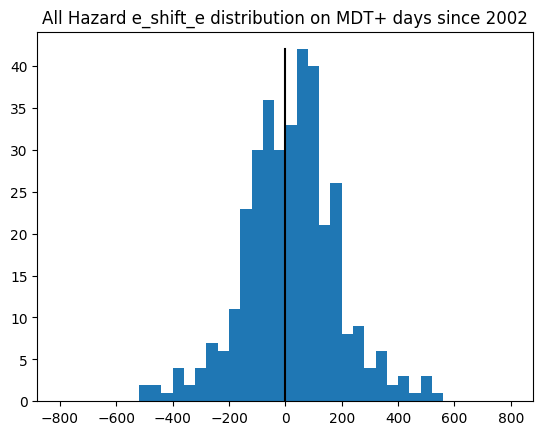

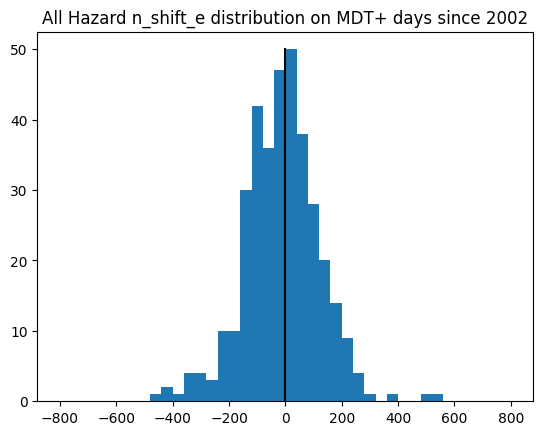

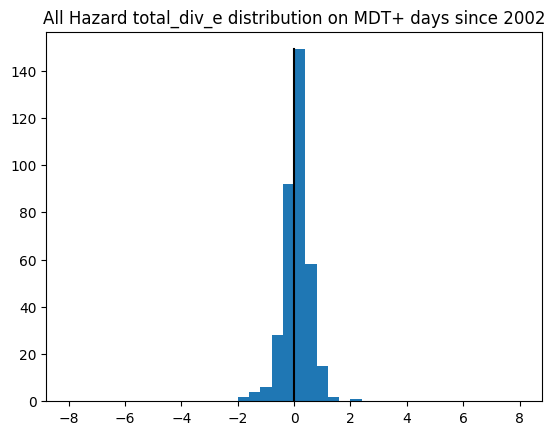

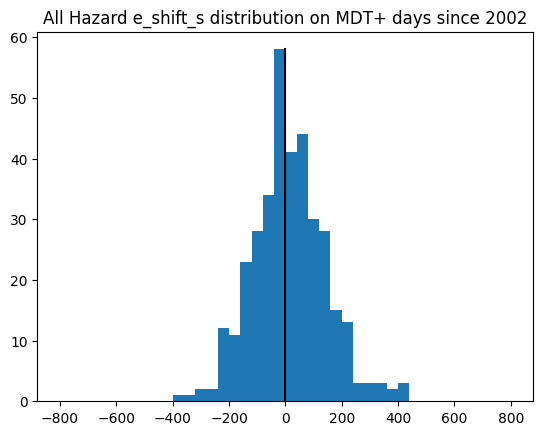

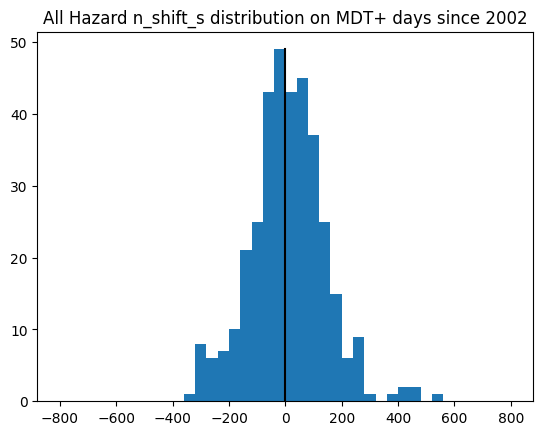

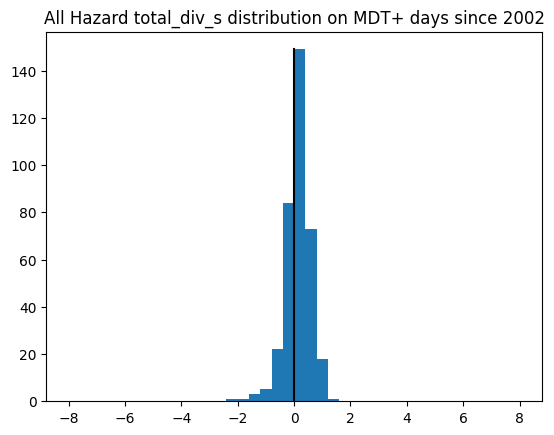

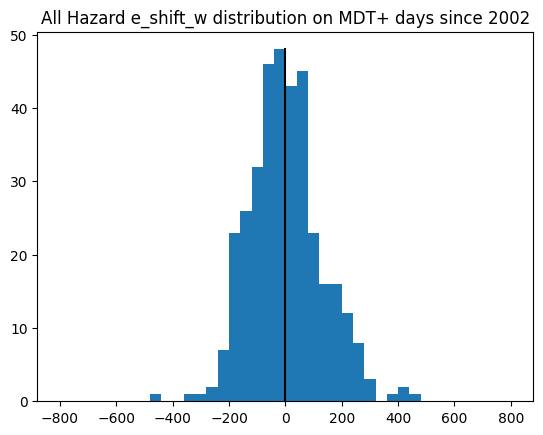

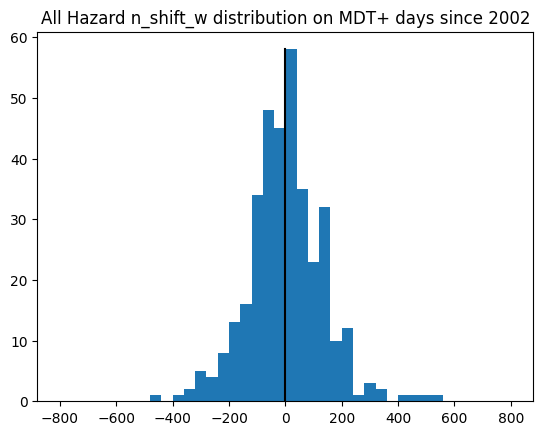

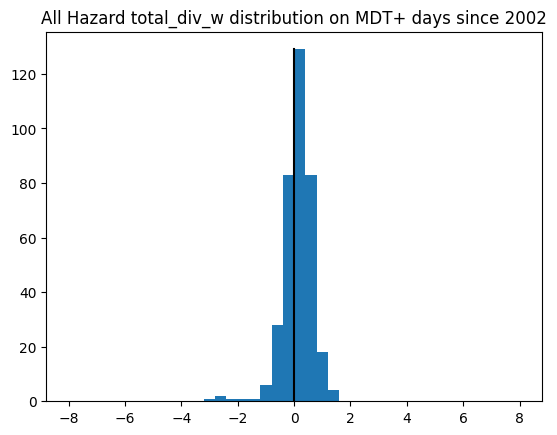

In [40]:
hazard_types= ['Wind', 'Hail', 'Tornado', 'All Hazard']
vs = ['e_shift',
 'n_shift',
 'total_div',
 'e_shift_n',
 'n_shift_n',
 'total_div_n',
 'e_shift_e',
 'n_shift_e',
 'total_div_e',
 'e_shift_s',
 'n_shift_s',
 'total_div_s',
 'e_shift_w',
 'n_shift_w',
 'total_div_w']
for hazard in hazard_types:
    for v in vs:
        ds_hazard = ds.sel(hazard = hazard)[v]
        if 'div' in v: 
            y, _, _ = plt.hist(ds_hazard, bins = 40, range = (-8, 8))
        else:
            y, _, _ = plt.hist(ds_hazard/1000, bins = 40, range = (-800, 800))
        plt.plot([0, 0], [0, y.max()], color='k', linestyle='-')
        plt.title(hazard + ' ' + v + ' distribution on MDT+ days since 2002')
        plt.show()

            

    

(array([1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 5.000e+00, 5.000e+00, 1.000e+01, 1.100e+01, 1.100e+01,
        1.600e+01, 1.300e+01, 1.700e+01, 8.000e+00, 1.400e+01, 1.500e+01,
        1.900e+01, 1.400e+01, 3.000e+01, 2.700e+01, 5.100e+01, 6.500e+01,
        1.460e+02, 3.540e+02, 8.390e+02, 3.597e+03, 1.545e+03, 7.220e+02,
        2.600e+02, 8.100e+01, 3.400e+01, 1.400e+01, 4.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([-8.35615007, -8.05444636, -7.75274265, -7.45103894, -7.14933524,
        -6.84763153, -6.54592782, -6.24422411, -5.9425204 , -5.64081669,
        -5.33911299, -5.03740928, -4.73570557, -4.43400186, -4.13229815,
        -3.83059444, -3.52889074, -3.22718703, -2.92548332, -2.62377961,
        -2.3220759 , -2.02037219, -1.71866849, -1.41696478, -1.11526107,
        -0.81355736, -0.51185365, -0.21014995,  0.09155376,  0.39325747,
         0.69496118,  0.99666489,  1.2983686 ,  1.6000723 ,  1.9

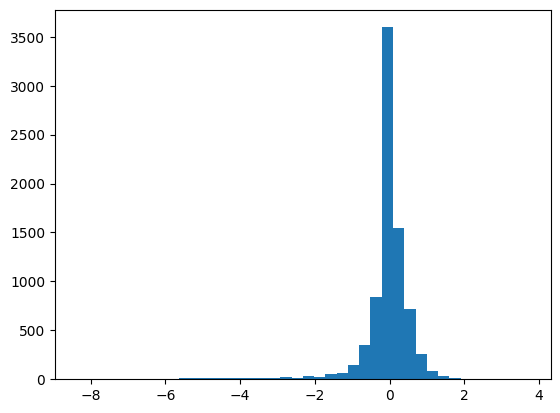

In [17]:
plt.hist(ds_hazard, bins = 40)